In [1]:
from openprompt.data_utils import InputExample
import torch
import pandas as pd
import os
import json, csv
from abc import ABC, abstractmethod
from collections import defaultdict, Counter
from typing import List, Dict, Callable

from openprompt.utils.logging import logger

from openprompt.data_utils.utils import InputExample
from openprompt.data_utils.data_processor import DataProcessor

import pandas as pd
import numpy as np
from tqdm import tqdm

from torchnlp.encoders import LabelEncoder

# first set up the dataprocessor for mortality prediction

In [2]:
# set dir to the mortality prediction data
data_dir = "../clinical-outcomes-data/mimic3-clinical-outcomes/mp/"

In [3]:
df = pd.read_csv(f"{data_dir}/train.csv")

In [4]:
len(df.id.unique())

33954

In [5]:
df

id                                               text  \
0      107384  CHIEF COMPLAINT: AMS, concern for toxic alcoho...   
1      101061  CHIEF COMPLAINT: abdominal pain\n\nPRESENT ILL...   
2      127180  CHIEF COMPLAINT: Bilateral Sub Dural Hematoma\...   
3      168339  CHIEF COMPLAINT: Intracranial bleed\n\nPRESENT...   
4      154044  CHIEF COMPLAINT: ischemic left foot\n\nPRESENT...   
...       ...                                                ...   
33949  122869  CHIEF COMPLAINT: Fever and neutropenia.\n\nPRE...   
33950  145612  CHIEF COMPLAINT: Chest pain.\n\nPRESENT ILLNES...   
33951  152495  CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...   
33952  182652  CHIEF COMPLAINT: Malaise, fever, chills, and L...   
33953  146659  CHIEF COMPLAINT: Altered mental status, bloody...   

       hospital_expire_flag  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
33949                     0  
33950                     0  
33951                     0  
33952                     0  
33953                     0  

[33954 rows x 3 columns]

In [14]:
df.loc[0]['text']

'CHIEF COMPLAINT: AMS, concern for toxic alcohol ingestion\n\nPRESENT ILLNESS: Mr. [**Known lastname 27389**] is a 39 year old man with h/o EtOH and polysubstance abuse, seizure disorder, who was found to be unresponsive while visiting his partner in the ICU earlier today. . The patient was visiting his partner in the ICU earlier today. He was awake and conversant in the morning with no acute complaints. He was noted to be sleeping on the floor, but walked to the chair by himself when he was awakened. Later in the afternoon, the patient was noted to still be asleep in the chair. He was unarousable with verbal stimuli or sternal rub, so he was taken down to the ED. . In the ED, the patient was initially altered, but was otherwise hemodynamically stable. No urine incontinence or e/o toxidromes. Labs notable for EtOH 86, Osms 366, anion gap 16, lactate 3.8. Utox positive for barbs, but Stox and Utox otherwise negative. Given high serum osmolar gap (60), toxicology was consulted for concer

<AxesSubplot:>

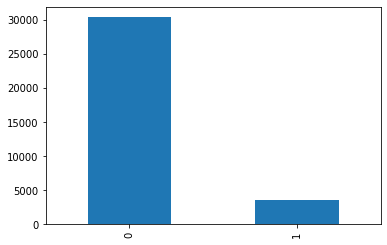

In [17]:
df.hospital_expire_flag.value_counts().plot(kind="bar")

In [23]:
# we actually want to convert the numerical labels to string 

df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})

In [25]:
df.hospital_expire_flag.unique()

array([0, 1])

In [34]:
class Mimic_Mortality_Processor(DataProcessor):


    '''
    Function to convert mimic mortality prediction dataset from the clinical outcomes paper: https://aclanthology.org/2021.eacl-main.75/
    
    to a open prompt ready dataset. 
    
    We also instantiate a LabelEncoder() class which is fitted to the given dataset. Fortunately it appears
    to create the same mapping for each set, given each set contains all classes.    
    
    '''
    # TODO Test needed
    def __init__(self):
        super().__init__()        

    def get_examples(self, data_dir, mode = "train", label_encoder = None,
                     generate_class_labels = False, class_labels_save_dir = "./scripts/mimic_mortality/"):

        path = f"{data_dir}/{mode}.csv"
        print(f"loading {mode} data")
        print(f"data path provided was: {path}")
        examples = []
        df = pd.read_csv(path)

        # map the binary classification label to a new string class label
        df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})
        
        # need to either initializer and fit the label encoder if not provided
        if label_encoder is None:
            self.label_encoder = LabelEncoder(np.unique(df["label"]).tolist(),reserved_labels = [])
        else: 
            print("we were given a label encoder")
            self.label_encoder = label_encoder

        print("label encoder idx to token: ", self.label_encoder.token_to_index)
        for idx, row in tqdm(df.iterrows()):
#             print(row)
            body, label = row['text'],row['label']
            print(f"text label is: {label}")
            label = self.label_encoder.encode(label)
            print(f"encoded label is: {label}")
#             print(f"body : {body}")
#             print(f"label: {label}")
#             print(f"labels original: {self.label_encoder.index_to_token[label]}")
            
            text_a = body.replace('\\', ' ')
            
            if label > 1:
                print("Why the fuck is there something above 1")
                
                example = InputExample(
                    guid=str(idx), text_a=text_a, label=int(label))
                examples.append(example)
            
        logger.info(f"Returning {len(examples)} samples!") 

#         now we want to return a list of the non-encoded labels based on the fitted label encoder
        if generate_class_labels:
        
            if not os.path.exists(class_labels_save_dir):
                os.makedirs(class_labels_save_dir)
            logger.info(f"Saving class labels to: {class_labels_save_dir}")
            class_labels = self.generate_class_labels()
            # write these to files as the classes for prompt learning pipeline           

            textfile = open(f"{class_labels_save_dir}/labels.txt", "w")

            for element in class_labels[:-1]:

                textfile.write(element + "\n")
            # now write the last item to the file
            textfile.write(class_labels[-1])
            textfile.close() 

        return examples

    def generate_class_labels(self):
        # now we want to return a list of the non-encoded labels based on the fitted label encoder
        try:
            return list(self.label_encoder.tokens.keys())
        except:
            print("No class labels as haven't fitted any data yet. Run get_examples first!")
            raise NotImplementedError

    
    def load_class_labels(self, file_path = "./scripts/mimic_mortality/labels.txt"):
        # function to load pre-generated class labels
        # returns list of class labels

        text_file = open(f"{file_path}", "r")

        class_labels = text_file.read().split("\n")

        return class_labels

In [35]:
# get different splits
dataset = {}
dataset['train'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}", mode = "train", generate_class_labels = True)
dataset['valid'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}",mode = "valid" )
dataset

loading train data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//train.csv
label encoder idx to token:  {'alive': 0, 'deceased': 1}


221it [00:00, 2207.79it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text la

471it [00:00, 2375.00it/s]


encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


709it [00:00, 2334.23it/s]

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
t

960it [00:00, 2401.88it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


1259it [00:00, 2610.44it/s]

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text

1551it [00:00, 2712.90it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


1823it [00:00, 2639.51it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


2348it [00:00, 2578.58it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded la

text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


2905it [00:01, 2635.24it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive


3432it [00:01, 2557.82it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


3969it [00:01, 2526.58it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


4495it [00:01, 2578.70it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


5006it [00:02, 2291.97it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


5512it [00:02, 2410.52it/s]

encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


6016it [00:02, 2461.31it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


6522it [00:02, 2480.07it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


7040it [00:02, 2531.86it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


7550it [00:03, 2536.33it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


7804it [00:03, 2281.62it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


8258it [00:03, 2099.86it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


8734it [00:03, 2208.21it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


9174it [00:03, 2121.12it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased


9626it [00:04, 2166.88it/s]

encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive


10145it [00:04, 2394.86it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
enco

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased


10640it [00:04, 2401.56it/s]

encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
enco

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: deceased


10881it [00:04, 2303.10it/s]

encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased


11363it [00:04, 2356.12it/s]

encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
enco

encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


11937it [00:04, 2615.03it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive


12534it [00:05, 2809.96it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
enco

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


13088it [00:05, 2562.26it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


13604it [00:05, 2412.34it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

encoded label is: 0


14088it [00:05, 2354.93it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


14571it [00:06, 2359.78it/s]

text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

encoded label is: 0
text label is: alive


15075it [00:06, 2435.69it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0


15555it [00:06, 2305.12it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased


16086it [00:06, 2466.42it/s]

encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


16334it [00:06, 2458.91it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
t

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


16860it [00:06, 2388.22it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

encoded label is: 0
text label is: alive
encoded label is: 0

17394it [00:07, 2531.70it/s]


text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: 

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


17911it [00:07, 2512.12it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


18436it [00:07, 2450.64it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0


18922it [00:07, 2297.88it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


19392it [00:08, 2322.59it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


19884it [00:08, 2395.77it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text la

encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive


20362it [00:08, 2360.21it/s]

encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
enco

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


20839it [00:08, 2315.46it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


21322it [00:08, 2366.19it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0


21827it [00:09, 2456.22it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


22073it [00:09, 2308.36it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded la

encoded label is: 0
text label is: alive
encoded label is: 0

22546it [00:09, 2268.74it/s]


text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label i

encoded label is: 0
text label is: alive


23070it [00:09, 2463.22it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

encoded label is: 0
text label is: alive
encoded label is: 0

23618it [00:09, 2614.01it/s]


text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label i

encoded label is: 0
text label is: alive
encoded label is: 0

24149it [00:09, 2608.60it/s]


text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label i

text label is: alive
encoded label is: 0
text label is: alive


24737it [00:10, 2769.18it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
enco

encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive


25285it [00:10, 2601.58it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded la

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


25806it [00:10, 2550.26it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

text label is: alive
encoded label is: 0
text label is: alive

26311it [00:10, 2443.94it/s]


encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encode

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


26820it [00:11, 2448.33it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0


27328it [00:11, 2488.25it/s]

text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

encoded label is: 0


27859it [00:11, 2408.85it/s]

text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


28102it [00:11, 2354.70it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
enco

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive

28565it [00:11, 2220.43it/s]


encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: ali

encoded label is: 0
text label is: alive
encoded label is: 0


29058it [00:11, 2356.28it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

encoded label is: 0
text label is: deceased
encoded label is: 1


29527it [00:12, 2304.70it/s]

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


30043it [00:12, 2277.83it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


30545it [00:12, 2334.27it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0


31060it [00:12, 2323.55it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


31521it [00:13, 2204.57it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


32000it [00:13, 2300.33it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive

32470it [00:13, 2293.61it/s]


encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
enc

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


32700it [00:13, 2207.13it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


33170it [00:13, 2196.12it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


33733it [00:13, 2518.96it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

text label is: alive
encoded label is: 0
text label is: alive

33954it [00:14, 2411.74it/s]



encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
loading valid data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//valid.csv
label encoder idx to token:  {'alive': 0, 'deceased': 1}


0it [00:00, ?it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 

text label is: alive
encoded label is: 0


207it [00:00, 2058.79it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

413it [00:00, 1894.31it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

617it [00:00, 1957.20it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

824it [00:00, 1997.92it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


1066it [00:00, 2147.00it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

1282it [00:00, 2104.11it/s]

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
t

1493it [00:00, 2090.55it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded

1755it [00:00, 2252.43it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


1991it [00:00, 2284.07it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is

2257it [00:01, 2396.35it/s]


encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded labe

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


2498it [00:01, 2238.52it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded la

2725it [00:01, 2209.36it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


2987it [00:01, 2327.35it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

3222it [00:01, 2325.81it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text la

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased


3464it [00:01, 2351.25it/s]

encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label

3701it [00:01, 2336.11it/s]


text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
tex

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive


3936it [00:01, 2270.33it/s]

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded

4221it [00:01, 2436.37it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0


4494it [00:01, 2521.51it/s]

text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
t

4748it [00:02, 2475.72it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label

encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: deceased
encoded label is: 1


4908it [00:02, 2280.98it/s]

text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: alive
encoded label is: 0
text label is: a

{'train': [], 'valid': []}

In [20]:
dataset['train']

[{
   "guid": "12",
   "label": 2,
   "meta": {},
   "text_a": "CHIEF COMPLAINT: Syncope, shortness of breath\n\nPRESENT ILLNESS: 89 F with history of breast cancer s/p lumpectomy in [**2145**], dementia, atrial fibrillation, PSVT, orthostatic hypotension and history of syncopal episodes and multiple falls with recent C2/3 spinous process fractures in [**10-5**], who presents after a syncopal episode with C2 spinous process fracture on CT.  Patient was in USOH at rehab (where she has had several falls), when to the bathroom to urinate, became dizzy, syncopized and \"hit the floor\" quickly. She landed on her left side, and is not sure whether she actually lost consciousness. (event not witnessed). She cannot recall any prodromal symptoms other than dizziness.  She was brought to [**Hospital1 **] [**Location (un) 620**], where she was found to be hypoxic to 87% on RA, Head CT neg, CXR showed fluffy bilateral infiltrates read as pulmonary edema, shoulder and pelvic XRay without fracture,

In [28]:
class_labels = Mimic_Mortality_Processor().load_class_labels()

In [9]:
class_labels

['alive', 'deceased']

In [29]:
le = LabelEncoder(class_labels, reserved_labels = [])

In [30]:
le.tokens.keys()

dict_keys(['alive', 'deceased'])

In [31]:
le.token_to_index

{'alive': 0, 'deceased': 1}